In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers.wrappers import TimeDistributed
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline  

Using Theano backend.


In [2]:
def train_test_split(data, p=None):
    if p:
        split_index = int(len(data) * p)

    train = data[:split_index]
    test = data[split_index:]
    return train, test, split_index

In [3]:
def lag_data(data, lag=1):
    data = list(data)
    X, y = [], []
    for i in range(len(data) - lag - 1):
        a = data[i: i + lag]
        X.append(a)
        y.append(data[i + lag])
    return np.array(X), np.array(y)

In [4]:
def split_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(df)
    train, test, split_index = train_test_split(data, p=0.7)
    X_train, y_train = lag_data(train, lag=lags)
    X_test, y_test = lag_data(test, lag=lags)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_train, y_train, X_test, y_test, scaler

In [5]:
def train_model(X_train, y_train, batch_size):
    model = create_network(lags, batch_size, retain_state=False)
    model.fit(X_train, y_train, nb_epoch=10, batch_size=14, verbose=0)

    state_model = create_network(lags, batch_size, retain_state=True)

    for i in range(10):
        state_model.fit(X_train, y_train, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
        state_model.reset_states()

    return model, state_model

In [6]:
def create_network(lags, batch_size, retain_state):
    if retain_state is False:
        batch_size = 1
    model = Sequential()
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(14, batch_input_shape=(batch_size, lags, 1), stateful=retain_state))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model

In [7]:
def evaluate_one_step_model(model, scaler, X_train, X_test, y_train, y_test, batch_size=None):
    if batch_size:
        train_preds = model.predict(X_train, batch_size)
        test_preds = model.predict(X_test, batch_size)
    else:
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)

    train_score = math.sqrt(mean_squared_error(y_train, train_preds))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, test_preds))
    print('Test Score: %.2f RMSE' % (test_score))
    
    return test_preds

# 1-Step Forecast

## Arrivals

In [8]:
arr = pd.read_csv("../data/Sample/333_arrivals.csv", header=None)[1]
arr.head()

0     2
1    21
2    13
3     5
4     7
Name: 1, dtype: int64

In [9]:
lags = 14
standard_batch_size = 6

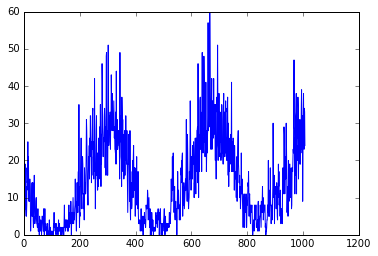

In [10]:
plt.plot(arr)
plt.show()

In [11]:
scale_X_train, scale_y_train, scale_X_test, scale_y_test, scaler = split_data(arr)
unscaled_y_train = scaler.inverse_transform(scale_y_train)
unscaled_y_test = scaler.inverse_transform(scale_y_test)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer

In [25]:
print len(scale_X_train)

690


In [12]:
model, state_model = train_model(scale_X_train, scale_y_train, standard_batch_size)

Epoch 1/1
1s - loss: 0.0298
Epoch 1/1
1s - loss: 0.0507
Epoch 1/1
1s - loss: 0.0427
Epoch 1/1
1s - loss: 0.0267
Epoch 1/1
1s - loss: 0.0217
Epoch 1/1
1s - loss: 0.0220
Epoch 1/1
1s - loss: 0.0236
Epoch 1/1
1s - loss: 0.0216
Epoch 1/1
1s - loss: 0.0222
Epoch 1/1
1s - loss: 0.0228


### No Memory

In [13]:
test_preds = evaluate_one_step_model(model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test)

Train Score: 6.72 RMSE
Test Score: 6.67 RMSE


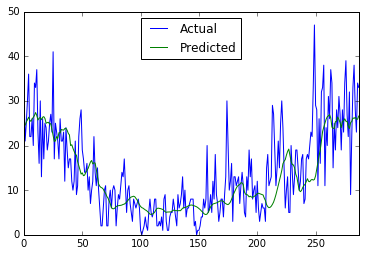

In [14]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

### Memory Between Batches

In [18]:
test_preds = evaluate_one_step_model(state_model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test, standard_batch_size)

Train Score: 9.32 RMSE
Test Score: 9.53 RMSE


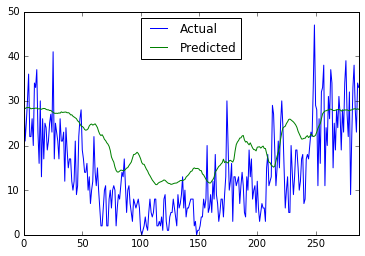

In [19]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

## Departures

In [20]:
dep = pd.read_csv("../data/Sample/333_departures.csv", header=None)[1]
dep.head()

0     3
1    18
2     6
3     6
4     9
Name: 1, dtype: int64

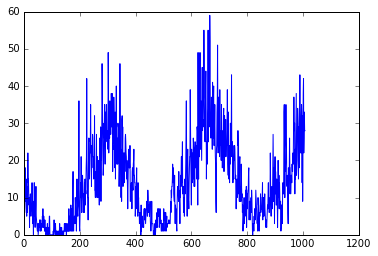

In [21]:
plt.plot(dep)
plt.show()

In [23]:
scale_X_train, scale_y_train, scale_X_test, scale_y_test, scaler = split_data(dep)
unscaled_y_train = scaler.inverse_transform(scale_y_train)
unscaled_y_test = scaler.inverse_transform(scale_y_test)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer

In [25]:
print len(scale_X_train)

690


In [27]:
model, state_model = train_model(scale_X_train, scale_y_train, standard_batch_size)

Epoch 1/1
1s - loss: 0.0347
Epoch 1/1
1s - loss: 0.0516
Epoch 1/1
1s - loss: 0.0305
Epoch 1/1
1s - loss: 0.0273
Epoch 1/1
1s - loss: 0.0238
Epoch 1/1
1s - loss: 0.0200
Epoch 1/1
1s - loss: 0.0219
Epoch 1/1
1s - loss: 0.0234
Epoch 1/1
1s - loss: 0.0217
Epoch 1/1
1s - loss: 0.0192


### No Memory

In [29]:
test_preds = evaluate_one_step_model(model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test)

Train Score: 7.16 RMSE
Test Score: 7.01 RMSE


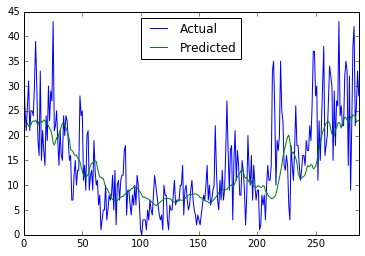

In [31]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

### Memory Between Batches

In [32]:
test_preds = evaluate_one_step_model(state_model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test, standard_batch_size)

Train Score: 8.26 RMSE
Test Score: 9.22 RMSE


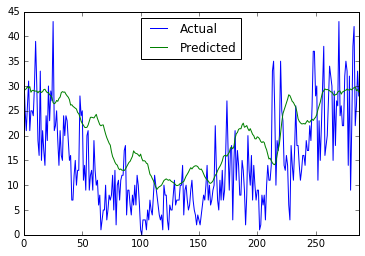

In [33]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

# 7-Step Forecast